In [1]:
import pandas as pd
import numpy as np
import qpsolvers as qp #Quadratic Programming package
from qpsolvers import solve_qp
import mgarch

# Define function to compute Black-Litterman weights based on the model inputs
def compute_black_litterman_weights(cov, pi, P, Q1, tau, omega):
    pi = pi.reshape(-1, 1)  # Ensure pi is a column vector
    # Compute the covariance matrix using Black-Litterman formula
    first_part = np.linalg.inv(np.linalg.inv(tau * cov) + np.dot(P.T, np.linalg.solve(omega, P)))
    # Compute the Black-Litterman expected returns
    second_part = np.dot(np.linalg.inv(tau * cov), pi) + np.dot(P.T, np.linalg.solve(omega, Q1))
    return np.dot(first_part, second_part).flatten()  # Flatten the matrix into a vector



def compute_mgarch_covariance(returns, ndays=1):
    vol = mgarch.mgarch()
    vol.fit(returns)
    cov_nextday = vol.predict(ndays) 
    cov = cov_nextday['cov']
    return cov

def compute_optimal_weights(cov, expected_returns, G):
    #Quadratic Programming optimization problem; https://scaron.info/doc/qpsolvers/quadratic-programming.html#primal-problem
    N = cov.shape[0]  # Number of assets
    Q = cov
    A = np.ones((1,N))
    c = -expected_returns.reshape([N,1]) #putting negative to follow solve_qp documentation
    b = np.array([1])
    G = G.reshape(1,N) #Retrieving last row of ESG score deficiencies
    h = np.asarray([25], dtype=float)
    lb = np.asarray([0.0001])*np.ones(N) # Lower bound ensuring positive weight
    ub = np.asarray([1.])*np.ones(N) # Upper Bound
    x = solve_qp(Q, expected_returns, G, h, A, b,lb,ub, solver="quadprog")
    return x

# Load data
stocks_data = pd.read_excel('Stock Prices.xlsx').set_index('Dates')
marketcap_data = pd.read_excel('Market Caps.xlsx').set_index('Dates')
ESG_data = pd.read_excel('ESG Scores.xlsx').set_index('Dates')

# Calculating ESG deficiency scores
ESG_data = 100 - ESG_data

# Define initial parameters for the optimization
capital = 1e10  # Initial capital
days_interval = 64  # Interval for recalculating portfolio
returns, dates, dates_traded, weights = [], [], [], []

# Main loop for processing data and calculating returns
for i in range(2213, len(stocks_data), days_interval):
    # Split data into training and testing sets based on the current interval
    stocks_training = stocks_data.iloc[0:i]
    stocks_testing = stocks_data.iloc[i:i+1]
    
    # Calculate returns and covariance matrix for the training set
    rts = stocks_training.pct_change().dropna().values  # Annualize daily returns
    rts_views = stocks_training.iloc[-days_interval:].pct_change().mean().values  # Views based on recent interval
    cov = compute_mgarch_covariance(rts, ndays=1)  # Annualized covariance matrix
    
    # Black-Litterman model parameters and calculations
    tau = 0.025  # Scaling factor for the uncertainty in the prior
    marketcaps = marketcap_data.iloc[i-1]  # Market capitalization at the current rebalance date
    market_weights = marketcaps / marketcaps.sum()  # Calculate market weights from market caps
    pi = tau * np.dot(cov, market_weights)  # Calculate implied excess returns
    views = np.diff(rts_views)  # Differences in views for constructing P matrix
    P = np.eye(len(views), len(stocks_training.columns))  # link matrix for picking views
    Q1 = (views / days_interval).reshape(-1, 1)  # Adjust views vector to an interval basis
    omega = tau * np.diag(np.var(rts, axis=0)[:len(views)])  # Uncertainty of views
    
    # ESG constraints
    G = ESG_data.iloc[i-1].to_numpy()
    
    # Compute Black-Litterman expected returns and optimal weights
    bl_expected_returns = compute_black_litterman_weights(cov, pi, P, Q1, tau, omega)
    optimal_weights = compute_optimal_weights(cov, bl_expected_returns,G)
    
    # Trading simulation for the current period
    last_closing_price = stocks_training.iloc[-1]
    amt_of_shares = np.floor((optimal_weights.flatten() * capital) / last_closing_price.values)  # Number of shares to buy
    abs_returns = (amt_of_shares * stocks_testing.values - amt_of_shares * last_closing_price.values)  # Calculate absolute returns
    percent_returns = abs_returns.sum() / capital  # Calculate percentage returns
    
    # Collect results from the current trading period
    returns.append(percent_returns)
    dates.append(stocks_testing.index[0])
    dates_traded.append(stocks_training.index[-1])
    weights.append(optimal_weights)

# Create DataFrame to display results and print it
results_df = pd.DataFrame({'Returns': returns}, index=dates)
print(results_df)



/Users/jorgehernandez/opt/anaconda3/lib/python3.8/site-packages/mgarch/mgarch.py:65: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.det(R_t[i])) + \


             Returns
2019-04-24 -0.001251
2019-07-25 -0.001433
2019-10-24 -0.001707
2020-01-28  0.004355
2020-04-29  0.026538
2020-07-30  0.033652
2020-10-29  0.008949
2021-02-02  0.000894
2021-05-05 -0.000348
2021-08-05  0.008319
2021-11-04  0.013556
2022-02-07  0.000094
2022-05-10 -0.003957
2022-08-11 -0.004758
2022-11-10  0.022413
2023-02-15  0.001020


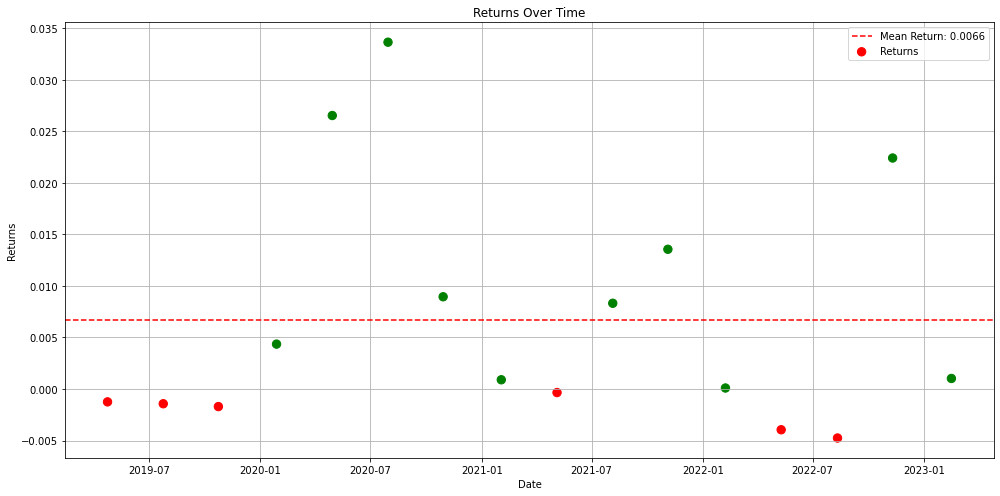

In [9]:
import matplotlib.pyplot as plt

# Calculate the mean return
mean_return = results_df['Returns'].mean()

# Define colors based on return values
colors = ['green' if ret > 0 else 'red' for ret in results_df['Returns']]

# Plotting the returns as scatter plot with color based on return value
plt.figure(figsize=(14, 7))
plt.scatter(results_df.index, results_df['Returns'], label='Returns', color=colors, s=70)  # Adjust size (s) as needed
plt.axhline(y=mean_return, color='red', linestyle='--', label=f"Mean Return: {mean_return:.4f}")
plt.title('Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig("Model 3 Returns Over Time.png", dpi=300)  # Adjust dpi for quality

plt.show()


In [3]:
# Reshape weights to 2D
weights_2d = np.array(weights).reshape(len(dates), -1)

# Convert reshaped weights to a DataFrame for easier plotting
weights_df = pd.DataFrame(weights_2d, index=dates, columns=stocks_data.columns)


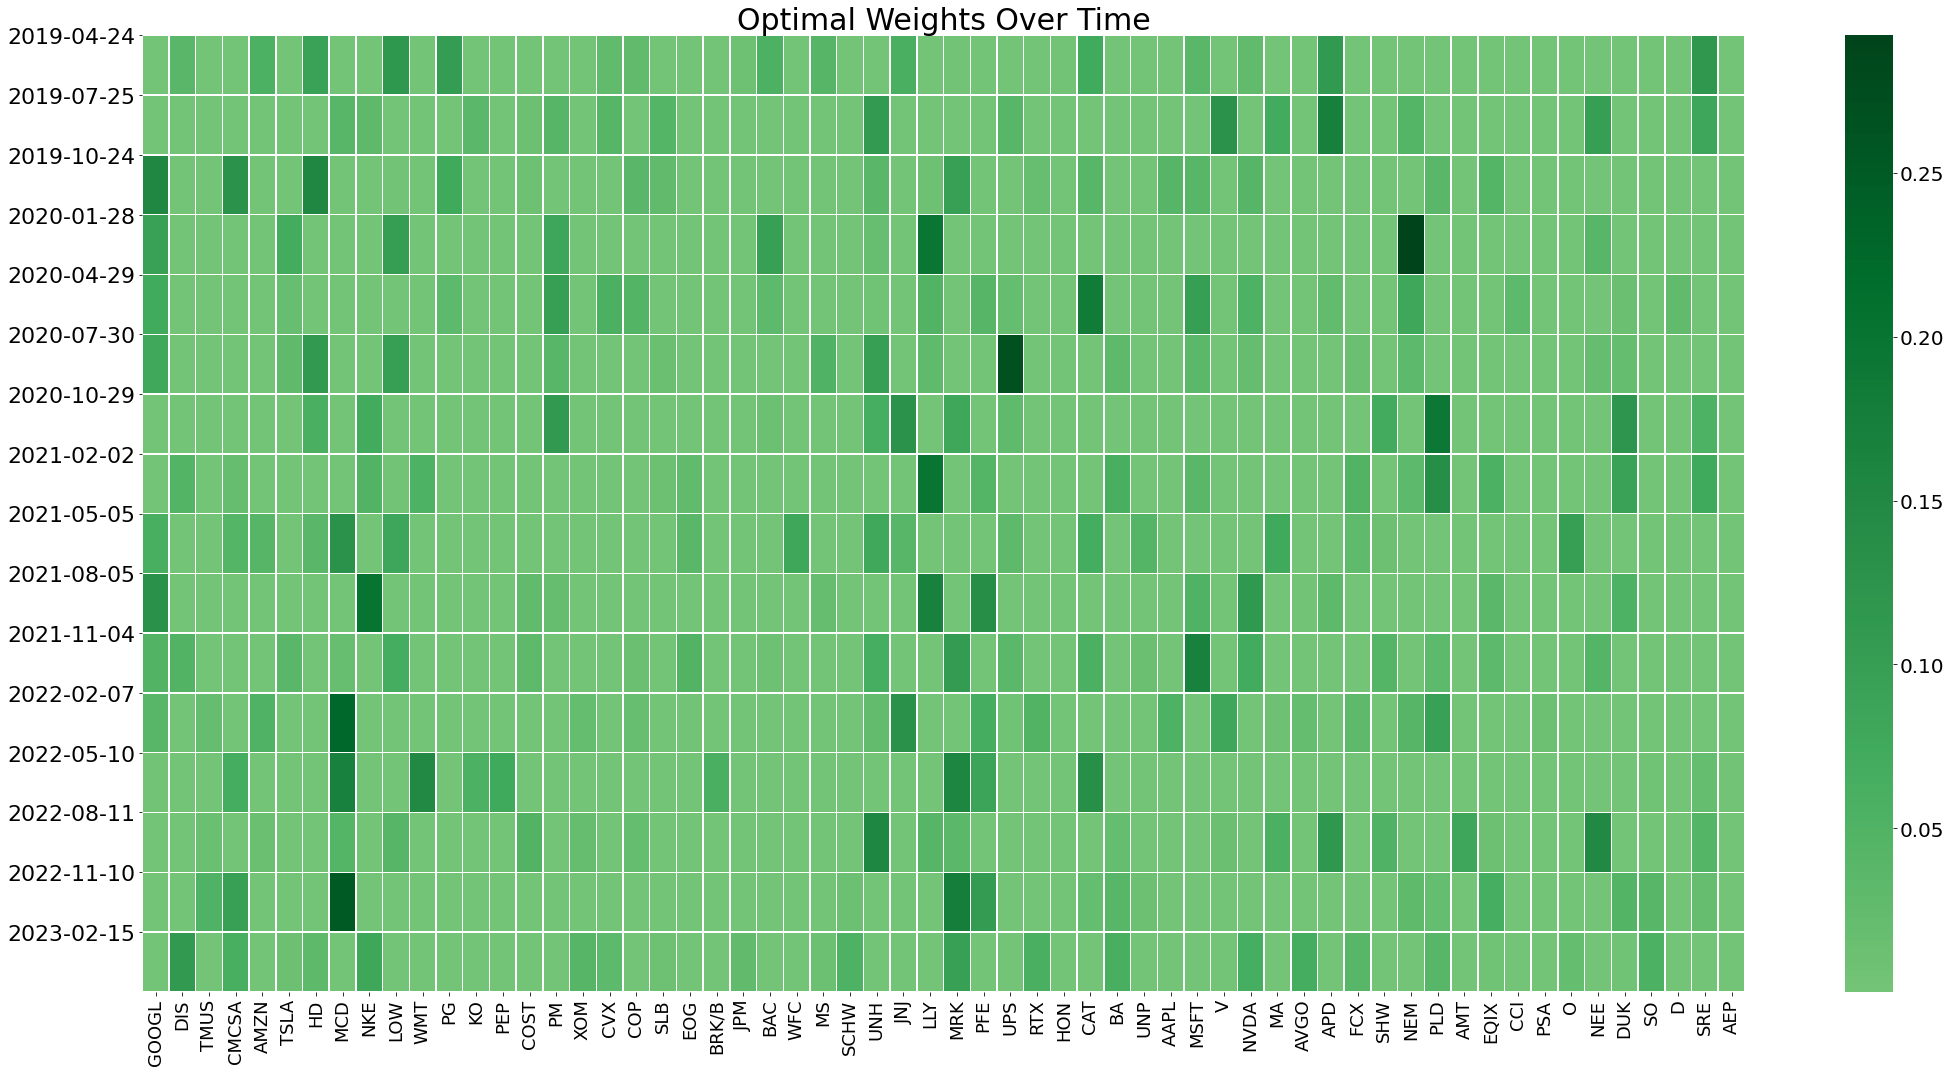

In [10]:
import seaborn as sns

# Remove "PX_LAST" suffix from stock names in the DataFrame
weights_df.columns = [col.replace('_PX_LAST', '') for col in weights_df.columns]

# Define a custom colormap with darker green for more positive values and lighter shades of green for values closer to 0
cmap = sns.color_palette("Greens", as_cmap=True)

# Plotting the heatmap
plt.figure(figsize=(30, 15))
heatmap = sns.heatmap(weights_df, cmap=cmap, cbar=True, linewidths=0.5, center=0)
plt.title('Optimal Weights Over Time', fontsize=30)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(ticks=np.arange(len(weights_df.index)), labels=weights_df.index.strftime('%Y-%m-%d'), fontsize=22)

# Access the color bar object and adjust the font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()

# Save the figure
plt.savefig("Model 3 Optimal Weights Over Time.png", dpi=300)  # Adjust dpi for quality
plt.show()

In [5]:
# Sum the weights for each company across all testing periods
total_weights = weights_df.sum()
top_10_companies = total_weights.nlargest(10).index
top_10_companies

Index(['MCD', 'MRK', 'LLY', 'GOOGL', 'UNH', 'CAT', 'NEM', 'PLD', 'LOW', 'HD'], dtype='object')

In [6]:
# Sum the weights for each company across all testing periods
total_weights = weights_df.sum()
top_10_companies = total_weights.nlargest(10).index

# Append suffix to each company name
formatted_company_names_positive = [name + "_ROBECOSAM_TOTAL_STBLY_RANK" for name in top_10_companies]

# Print the formatted company names for positive weights
print("Formatted company names for positive weights:")
print(formatted_company_names_positive)


Formatted company names for positive weights:
['MCD_ROBECOSAM_TOTAL_STBLY_RANK', 'MRK_ROBECOSAM_TOTAL_STBLY_RANK', 'LLY_ROBECOSAM_TOTAL_STBLY_RANK', 'GOOGL_ROBECOSAM_TOTAL_STBLY_RANK', 'UNH_ROBECOSAM_TOTAL_STBLY_RANK', 'CAT_ROBECOSAM_TOTAL_STBLY_RANK', 'NEM_ROBECOSAM_TOTAL_STBLY_RANK', 'PLD_ROBECOSAM_TOTAL_STBLY_RANK', 'LOW_ROBECOSAM_TOTAL_STBLY_RANK', 'HD_ROBECOSAM_TOTAL_STBLY_RANK']


In [7]:
# Filter the ESG data based on the trading dates
esg_scores_trades = ESG_data.loc[dates_traded]

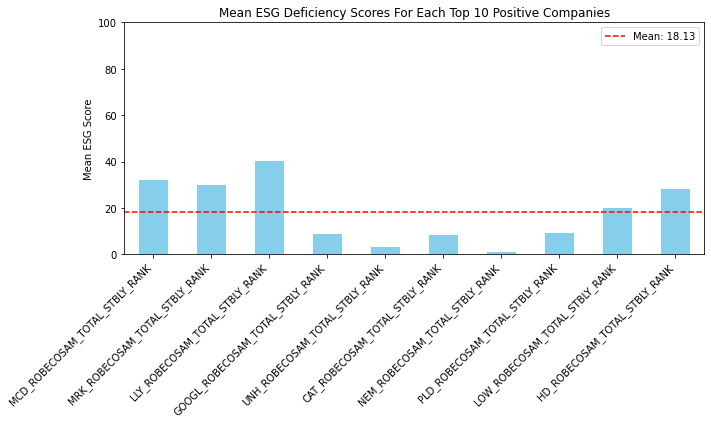

In [11]:
# Calculate the mean of the ESG scores for the specified formatted company names
mean_scores_pos = esg_scores_trades[formatted_company_names_positive].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
mean_scores_pos.plot(kind='bar', color='skyblue')
plt.title('Mean ESG Deficiency Scores For Each Top 10 Positive Companies')
plt.ylabel('Mean ESG Score')
plt.xticks(rotation=45, ha='right')

# Set y-axis limits
plt.ylim(0, 100)

# Calculate and add a red horizontal line for the mean
mean_value_pos = mean_scores_pos.mean()
plt.axhline(y=mean_value_pos, color='red', linestyle='--', label=f'Mean: {mean_value_pos:.2f}')
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig("Model 3 Mean ESG Score Top 10 Pos.png", dpi=300)  # Adjust dpi for quality
plt.show()